# Train

this script is to train the model after the parameters have been optimised.
The final model is output to the output directory in the current directory. This can be changed as described in the [Simple transformers docs](https://simpletransformers.ai/docs/installation/).
THis script also shows how the target classification can be prepared/trained.

### SDG Classifier

In [1]:
import wandb
import torch
import sklearn
import itertools
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from simpletransformers.classification import MultiLabelClassificationModel, MultiLabelClassificationArgs

In [2]:
# see GPU avaialability
cuda_available = torch.cuda.is_available()

% PER CLASS:

 SDG1      4.995375
SDG2      4.687018
SDG3      5.087882
SDG4      3.669442
SDG5      4.687018
SDG6      5.026210
SDG7      5.272895
SDG8      6.259636
SDG9      5.735430
SDG10     5.550416
SDG11     4.347826
SDG12     5.889608
SDG13    10.730805
SDG14     5.365402
SDG15     6.475486
SDG16     5.550416
SDG17    10.669134
dtype: float64


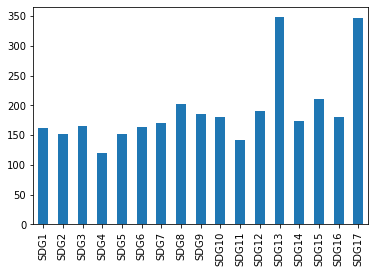

In [3]:
# import data
data = pd.read_csv('OneHot_Combined_cln_utf8.tsv', sep='\t')
data = data[data['source']!='SASDG_Hub'] #keep the articles classified by Willem separate as an unseen testing set
data = data.iloc[-1000:,:] # select a small subset of the data (last 1000 rows)

# reformat data
sdg_lst = ['SDG1','SDG2','SDG3','SDG4','SDG5','SDG6','SDG7','SDG8','SDG9','SDG10','SDG11','SDG12','SDG13','SDG14','SDG15','SDG16','SDG17']
data['y'] = data[sdg_lst].values.tolist()
y = data['y']
X = data['abstract']

# plot ratio of data
class_weight = (data[sdg_lst].sum()/ data[sdg_lst].sum().sum())
print('% PER CLASS:\n\n', class_weight*100)
data[sdg_lst].sum().plot.bar()
plt.show()

# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# add data to dataframes
train_df = pd.DataFrame()
train_df['text'] = X_train
train_df['labels'] = y_train
train_df.reset_index(inplace=True, drop=True)

eval_df = pd.DataFrame()
eval_df['text'] = X_val
eval_df['labels'] = y_val
eval_df.reset_index(inplace=True, drop=True)

# get number of classes
label_count = len(sdg_lst)

In [4]:
# train with optimal parameters from parameter tunign results
# logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# create function for creating layer learning rate dictionary
# this is used for freezing the number of layers from the first layer -> x layer
def create_custom_layer_dict_lst(x):    
    # get list of number of layers
    # layers_lst = [0]
    # for i in model.get_named_parameters():
    #     layers_lst.append(int(re.findall(r"layer\.(\d+)", i)[0]))
    #     layers_lst = list(set(layers_lst))
    # create dictionary of layers to freeze
    layer_dict_lst = []
    for i in range(x+1):
        layer_dict_lst.append({'layer':i, 'lr':0.0})
    return layer_dict_lst

# set threshold value here to calculate metrics accurately
threshold_val = 0.1

# Optional model configuration (all parameters defind in sweep config in parameter optimisation are now stated here)
model_args = MultiLabelClassificationArgs(fp16= False,
                                          manual_seed = 4,
                                          use_multiprocessing = True,
                                          overwrite_output_dir=True,
                                          evaluate_during_training = True,
                                          num_train_epochs=3,
                                          learning_rate=0.0001,
                                          train_batch_size=20,
                                          eval_batch_size=20,
                                          warmup_steps=100,
                                          weight_decay=0.09,
                                          threshold=threshold_val, # see value above
                                          custom_layer_parameters=create_custom_layer_dict_lst(0),
                                          wandb_project = 'sasdghub_ml_classify',
                                          wandb_kwargs={
                                              'entity':'sasdghub'
                                                       }
                                         )

# Create a MultiLabelClassificationModel
model = MultiLabelClassificationModel(
        "xlnet",
        "xlnet-base-cased",
        num_labels=label_count,
        args=model_args,
        use_cuda=cuda_available,
        pos_weight=list((1/label_count)/class_weight),
)

# create functions for additional evaluation outputs
def acc_result(true, pred):
    pred=(pred>=threshold_val).astype(int)
    acc_sum = 0
    for i in range(true.shape[0]):
        acc_sum += sklearn.metrics.accuracy_score(true[i], pred[i])    
    acc = acc_sum/true.shape[0]
    return acc

def f1_macro_result(true, pred):
    pred=(pred>=threshold_val).astype(int)
    f1 = sklearn.metrics.f1_score(true, pred, average='samples')
    return f1

def cm_wandb_result(true, pred):
    pred=(pred>=threshold_val).astype(int)
    # modify labels and fill all combinations to use wand multiclass confusion matrix visually
    d=true-pred
    t_d = (d==1)
    p_d = (d==-1)
    n_d = (d==0)
    idx_ar = np.array(range(0,true.shape[1]))
    idx = np.tile(idx_ar,true.shape[0]).reshape(true.shape[0],true.shape[1])
    n_labels = idx[n_d]
    t_lst = []
    for row in t_d:
        if row.sum()==0:
            t_lst.append(idx_ar)
        else:
            t_lst.append(idx_ar[row])
    p_lst = []
    for row in p_d:
        if row.sum()==0:
            p_lst.append(idx_ar)
        else:
            p_lst.append(idx_ar[row])
    for i in range(len(t_lst)):
        fill_ar = np.array(list(itertools.product(p_lst[i], t_lst[i])))
        t_labels = np.append(n_labels,fill_ar[:,0].tolist())
        p_labels = np.append(n_labels,fill_ar[:,1].tolist())
    wandb_cm = wandb.plot.confusion_matrix(probs=None, y_true=t_labels, preds=p_labels, class_names=sdg_lst)
    return wandb_cm

def cm_result(true, pred):
    pred=(pred>=threshold_val).astype(int)
    cm = sklearn.metrics.multilabel_confusion_matrix(true, pred)
    return cm

def cm_avg_result(true, pred):
    pred=(pred>=threshold_val).astype(int)
    cm = sklearn.metrics.multilabel_confusion_matrix(true, pred)
    cm_avg = cm.sum(axis=0)/true.shape[1]
    return cm_avg

# Train the model
model.train_model(train_df,
                      verbose=True,
                      eval_df=eval_df,
                      accuracy=acc_result,
                      f1_macro=f1_macro_result,
                      cm=cm_result,
                      cm_avg=cm_avg_result,
                      wandb_cm=cm_wandb_result)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(
    eval_df,
    verbose=True,
    accuracy=acc_result,
    f1_macro=f1_macro_result,
    cm=cm_result,
    cm_avg=cm_avg_result,
    wandb_cm=cm_wandb_result
)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream tas

  0%|          | 0/700 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_xlnet_128_0_2
C:\Users\GCM\anaconda3\envs\NLP\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.
wandb: Currently logged in as: christopher-marais (sasdghub). Use `wandb login --relogin` to force relogin


Running Epoch 0 of 3:   0%|          | 0/35 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 1 of 3:   0%|          | 0/35 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 2 of 3:   0%|          | 0/35 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2
INFO:simpletransformers.classification.classification_model: Training of xlnet model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'LRAP': 0.7971279091690512, 'accuracy': 0.5605882352941168, 'f1_macro': 0.3969037527561411, 'cm': array([[[137, 107],
        [ 14,  42]],

       [[ 89, 159],
        [  6,  46]],

       [[106, 140],
        [  3,  51]],

       [[159, 100],
        [  5,  36]],

       [[135, 117],
        [  5,  43]],

       [[ 84, 173],
        [  1,  42]],

       [[ 97, 158],
        [  1,  44]],

       [[130, 111],
        [  8,  51]],

       [[112, 123],
        [  7,  58]],

       [[121, 125],
        [  7,  47]],

       [[ 56, 201],
        [  1,  42]],

       [[129, 116],
        [  1,  54]],

       [[103,  85],
        [  2, 110]],

       [[134, 112],
        [  1,  53]],

       [[122, 115],
        [  2,  61]],

       [[150,  98],
        [ 11,  41]],

       [[ 76, 125],
        [  1,  98]]], dtype=int64), 'cm_avg': array([[114.11764706, 127.35294118],
       [  4.47058824,  54.05882353]]), 'wandb_cm': <wandb.viz.Cust